# **Feature Engineering**

## Objectives

* Create new features to improve model predictions.
* Transform and combine existing features.
* Explore the relationships between features and the target variable.

## Inputs

* Cleaned dataset: `outputs/datasets/collection/HousePricesRecords.csv`
* Data with handled missing values and correct data types.

## Outputs

* New dataset with engineered features: `outputs/datasets/feature_engineered/HousePricesFeatures.csv`
* Visualizations (if applicable): Charts showing feature relationships and distributions.


___

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/Heritage-Housing-Issues'

___

## Load data

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy.stats as stats
import json
from feature_engine.encoding import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from feature_engine.selection import SmartCorrelatedSelection
from feature_engine.transformation import BoxCoxTransformer, YeoJohnsonTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from joblib import dump


df_cleaned = pd.read_csv("outputs/datasets/collection/HousePricesCleaned.csv")
print(df_cleaned[['2ndFlrSF', 'BedroomAbvGr', 'SalePrice']].head())

   2ndFlrSF  BedroomAbvGr  SalePrice
0     854.0           3.0   208500.0
1       0.0           3.0   181500.0
2     866.0           3.0   223500.0
3       0.0           3.0   140000.0
4       0.0           4.0   250000.0


In [5]:
df_cleaned.dtypes

1stFlrSF        float64
2ndFlrSF        float64
BedroomAbvGr    float64
BsmtExposure     object
BsmtFinSF1      float64
BsmtFinType1     object
BsmtUnfSF       float64
GarageArea      float64
GarageFinish     object
GarageYrBlt     float64
GrLivArea       float64
KitchenQual      object
LotArea         float64
LotFrontage     float64
MasVnrArea      float64
OpenPorchSF     float64
OverallCond       int64
OverallQual       int64
TotalBsmtSF     float64
YearBuilt         int64
YearRemodAdd      int64
SalePrice       float64
dtype: object

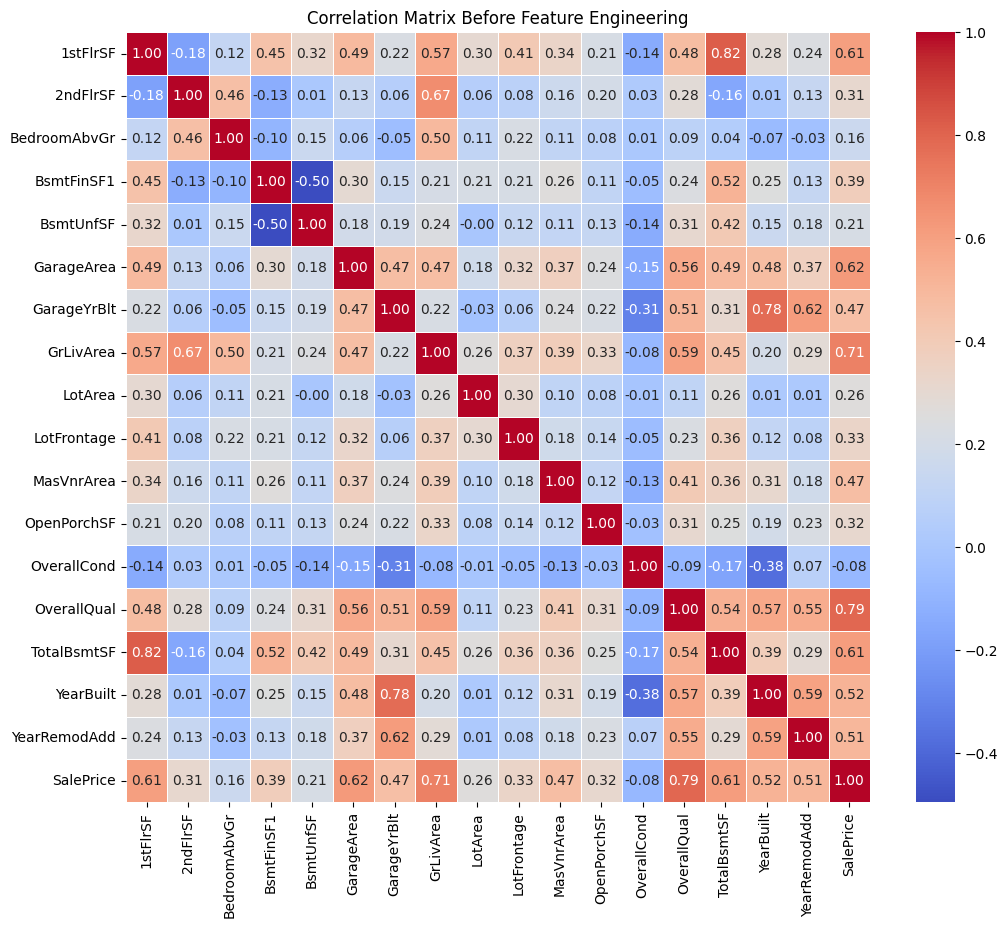

In [6]:
# Show the correlation matrix before feature engineering
correlation_matrix_before = df_cleaned.select_dtypes(include=['float64', 'int64']).corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_before, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix Before Feature Engineering")
plt.show()

**Correlation Matrix Before Feature Engineering**

The correlation matrix helps see how features relate to the target "SalePrice" before starting the feature engineering process. This helps decide which features are important and which can be combined or removed to make the model better.

Key Insights:

* **GrLivArea (0.71)** and **OverallQual (0.79)** have strong positive links to "SalePrice," making them important predictors.

* **GarageArea (0.62)** and **TotalBsmtSF (0.61)** also have strong positive links, showing that bigger garages and basements add value to house prices.

* **BedroomAbvGr (0.16)** and **OverallCond (-0.08)** have weak links to "SalePrice". These may be improved, combined, or removed.

___

Remove features with negative correlation to SalesPrice.

In [7]:
# Filter features with negative correlation with SalePrice
negative_corr_features = correlation_matrix_before['SalePrice'][correlation_matrix_before['SalePrice'] < 0].index.tolist()

# Print features with negative correlations
print("Features with negative correlation to SalePrice:")
print(negative_corr_features)

# Remove these features from the cleaned dataset
df_cleaned = df_cleaned.drop(columns=negative_corr_features)
print(f"Dataset shape after removing negative correlation features: {df_cleaned.shape}")

Features with negative correlation to SalePrice:
['OverallCond']
Dataset shape after removing negative correlation features: (1460, 21)


In [8]:
def compare_transformations(df_cleaned, variable):
    """
    Perform and visualize various transformations for a specific variable.
    """
    original = df_cleaned[variable].dropna()  # Handle NaN values

    # Shift negative values for Box-Cox
    if original.min() <= 0:
        shift_value = abs(original.min()) + 1
        print(f"Shifting {variable} by {shift_value} for Box-Cox transformation.")
        original += shift_value

    # Apply transformations
    transformations = {
        "Original": original,
        "Log": np.log1p(original),
        "Box-Cox": BoxCoxTransformer(variables=[variable]).fit_transform(original.to_frame())[variable],
        "Yeo-Johnson": YeoJohnsonTransformer(variables=[variable]).fit_transform(original.to_frame())[variable]
    }
    
    # Plot results
    fig, axes = plt.subplots(len(transformations), 3, figsize=(15, 5 * len(transformations)))
    fig.suptitle(f"Transformation Analysis for {variable}", fontsize=16, y=1.02)
    
    for i, (name, transformed) in enumerate(transformations.items()):
        # Histogram
        axes[i, 0].hist(transformed, bins=30, alpha=0.7)
        axes[i, 0].set_title(f"{name} - Histogram")
        
        # QQ-plot
        stats.probplot(transformed, dist="norm", plot=axes[i, 1])
        axes[i, 1].set_title("QQ-Plot")
        
        # Boxplot
        axes[i, 2].boxplot(transformed, vert=False)
        axes[i, 2].set_title("Boxplot")
    
    plt.tight_layout()
    plt.show()


Analyzing transformations for: GrLivArea


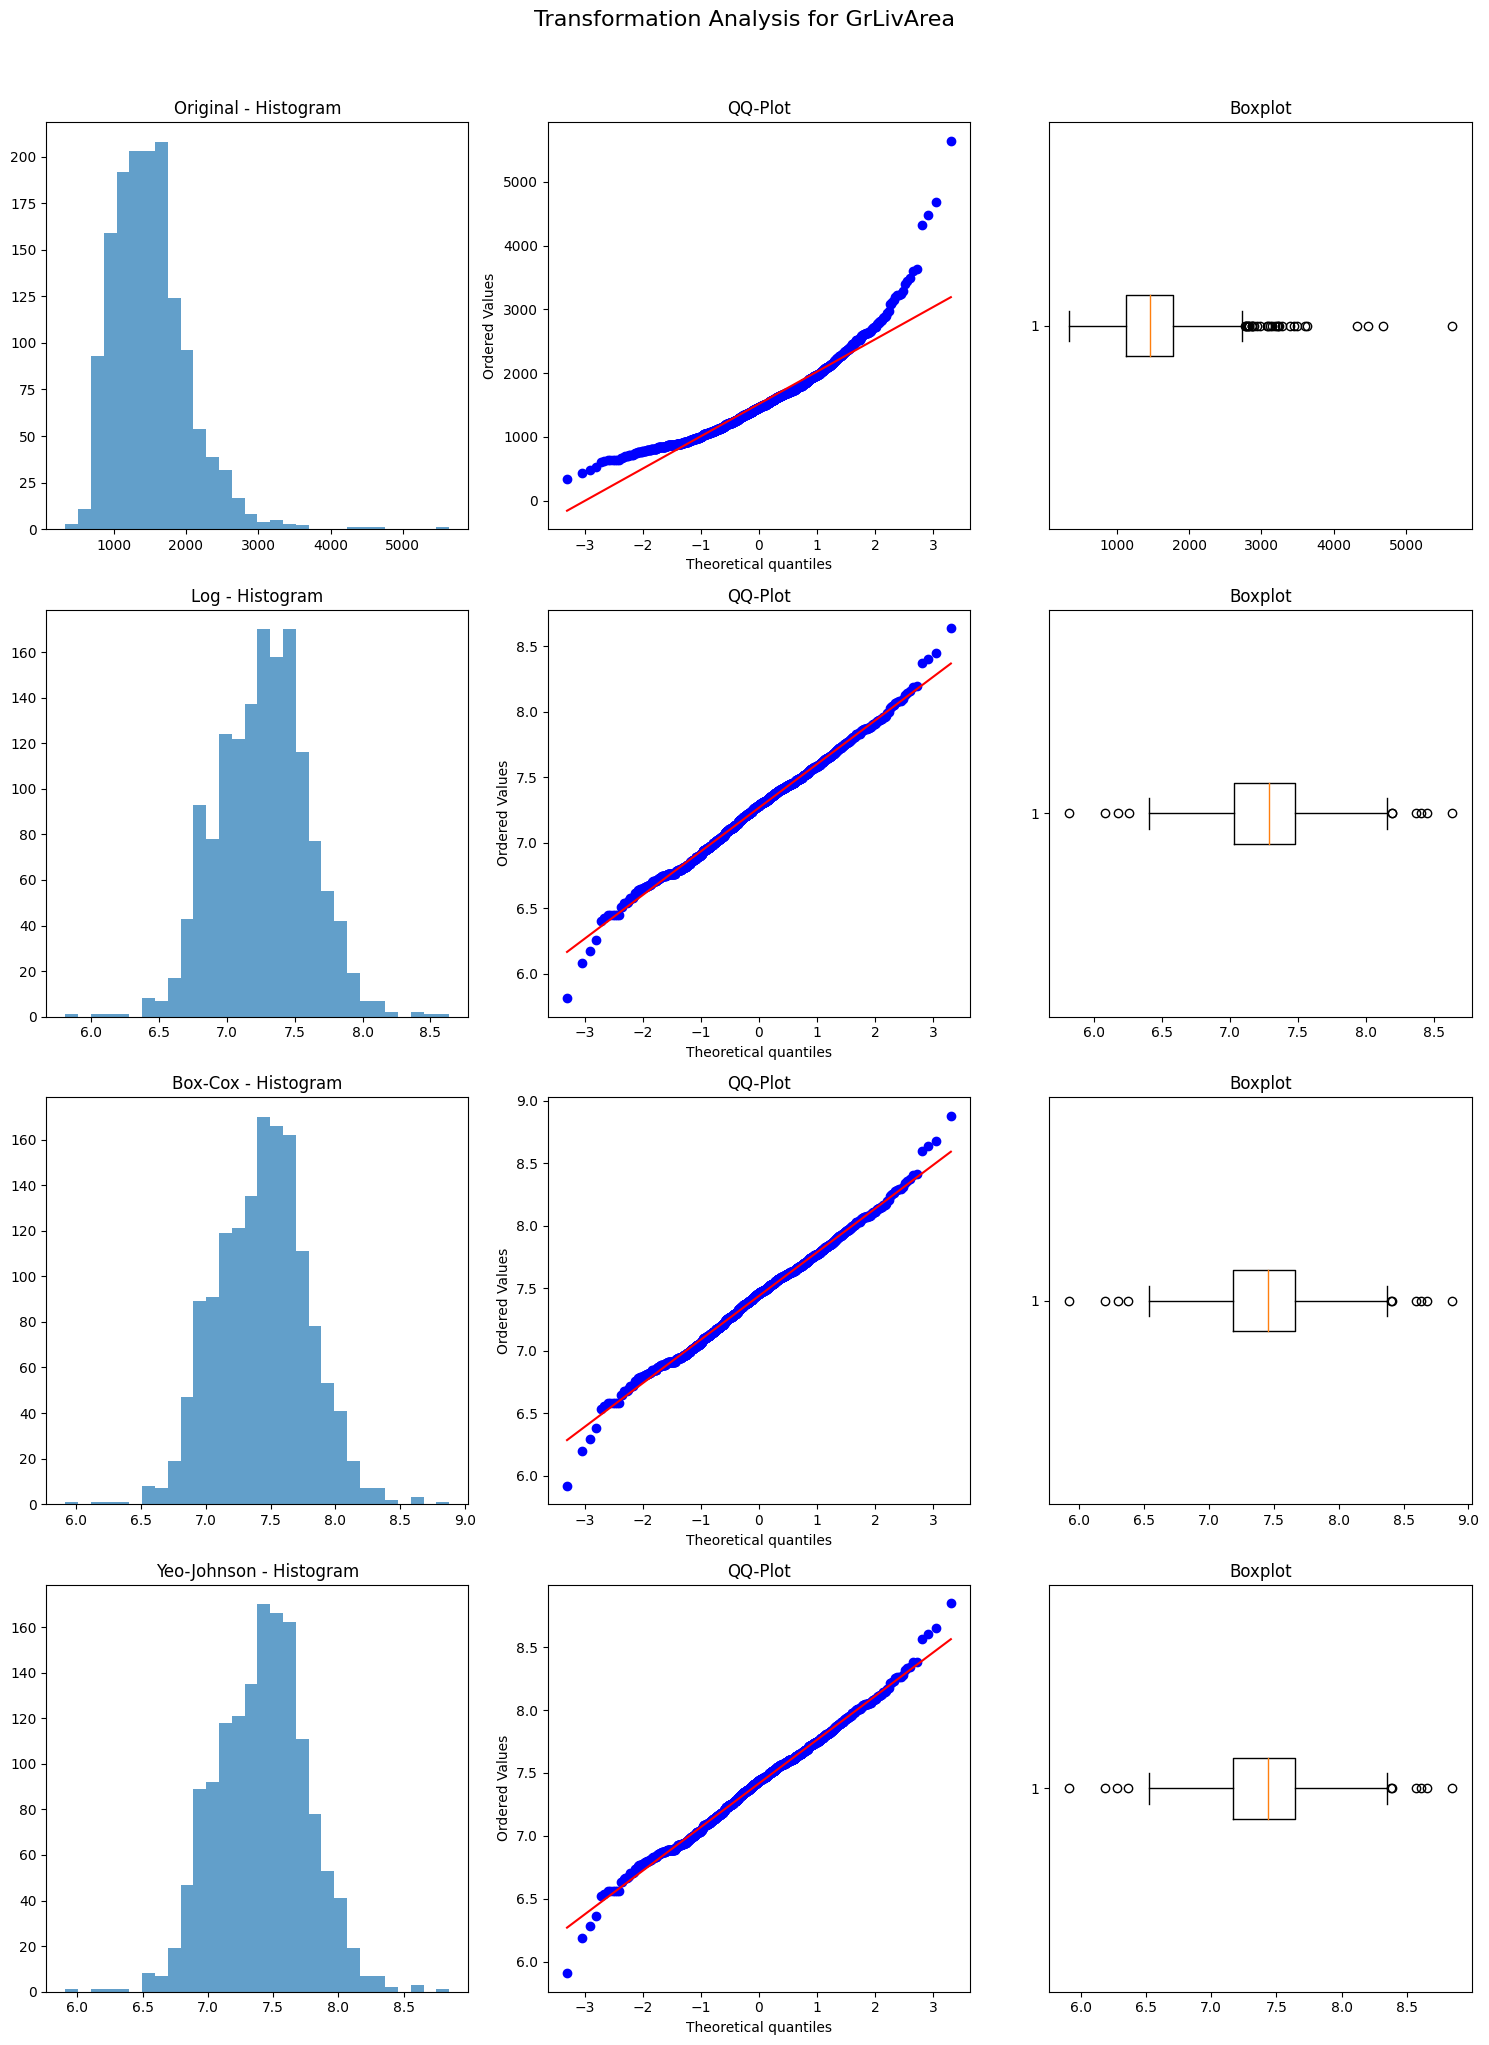

Analyzing transformations for: OverallQual


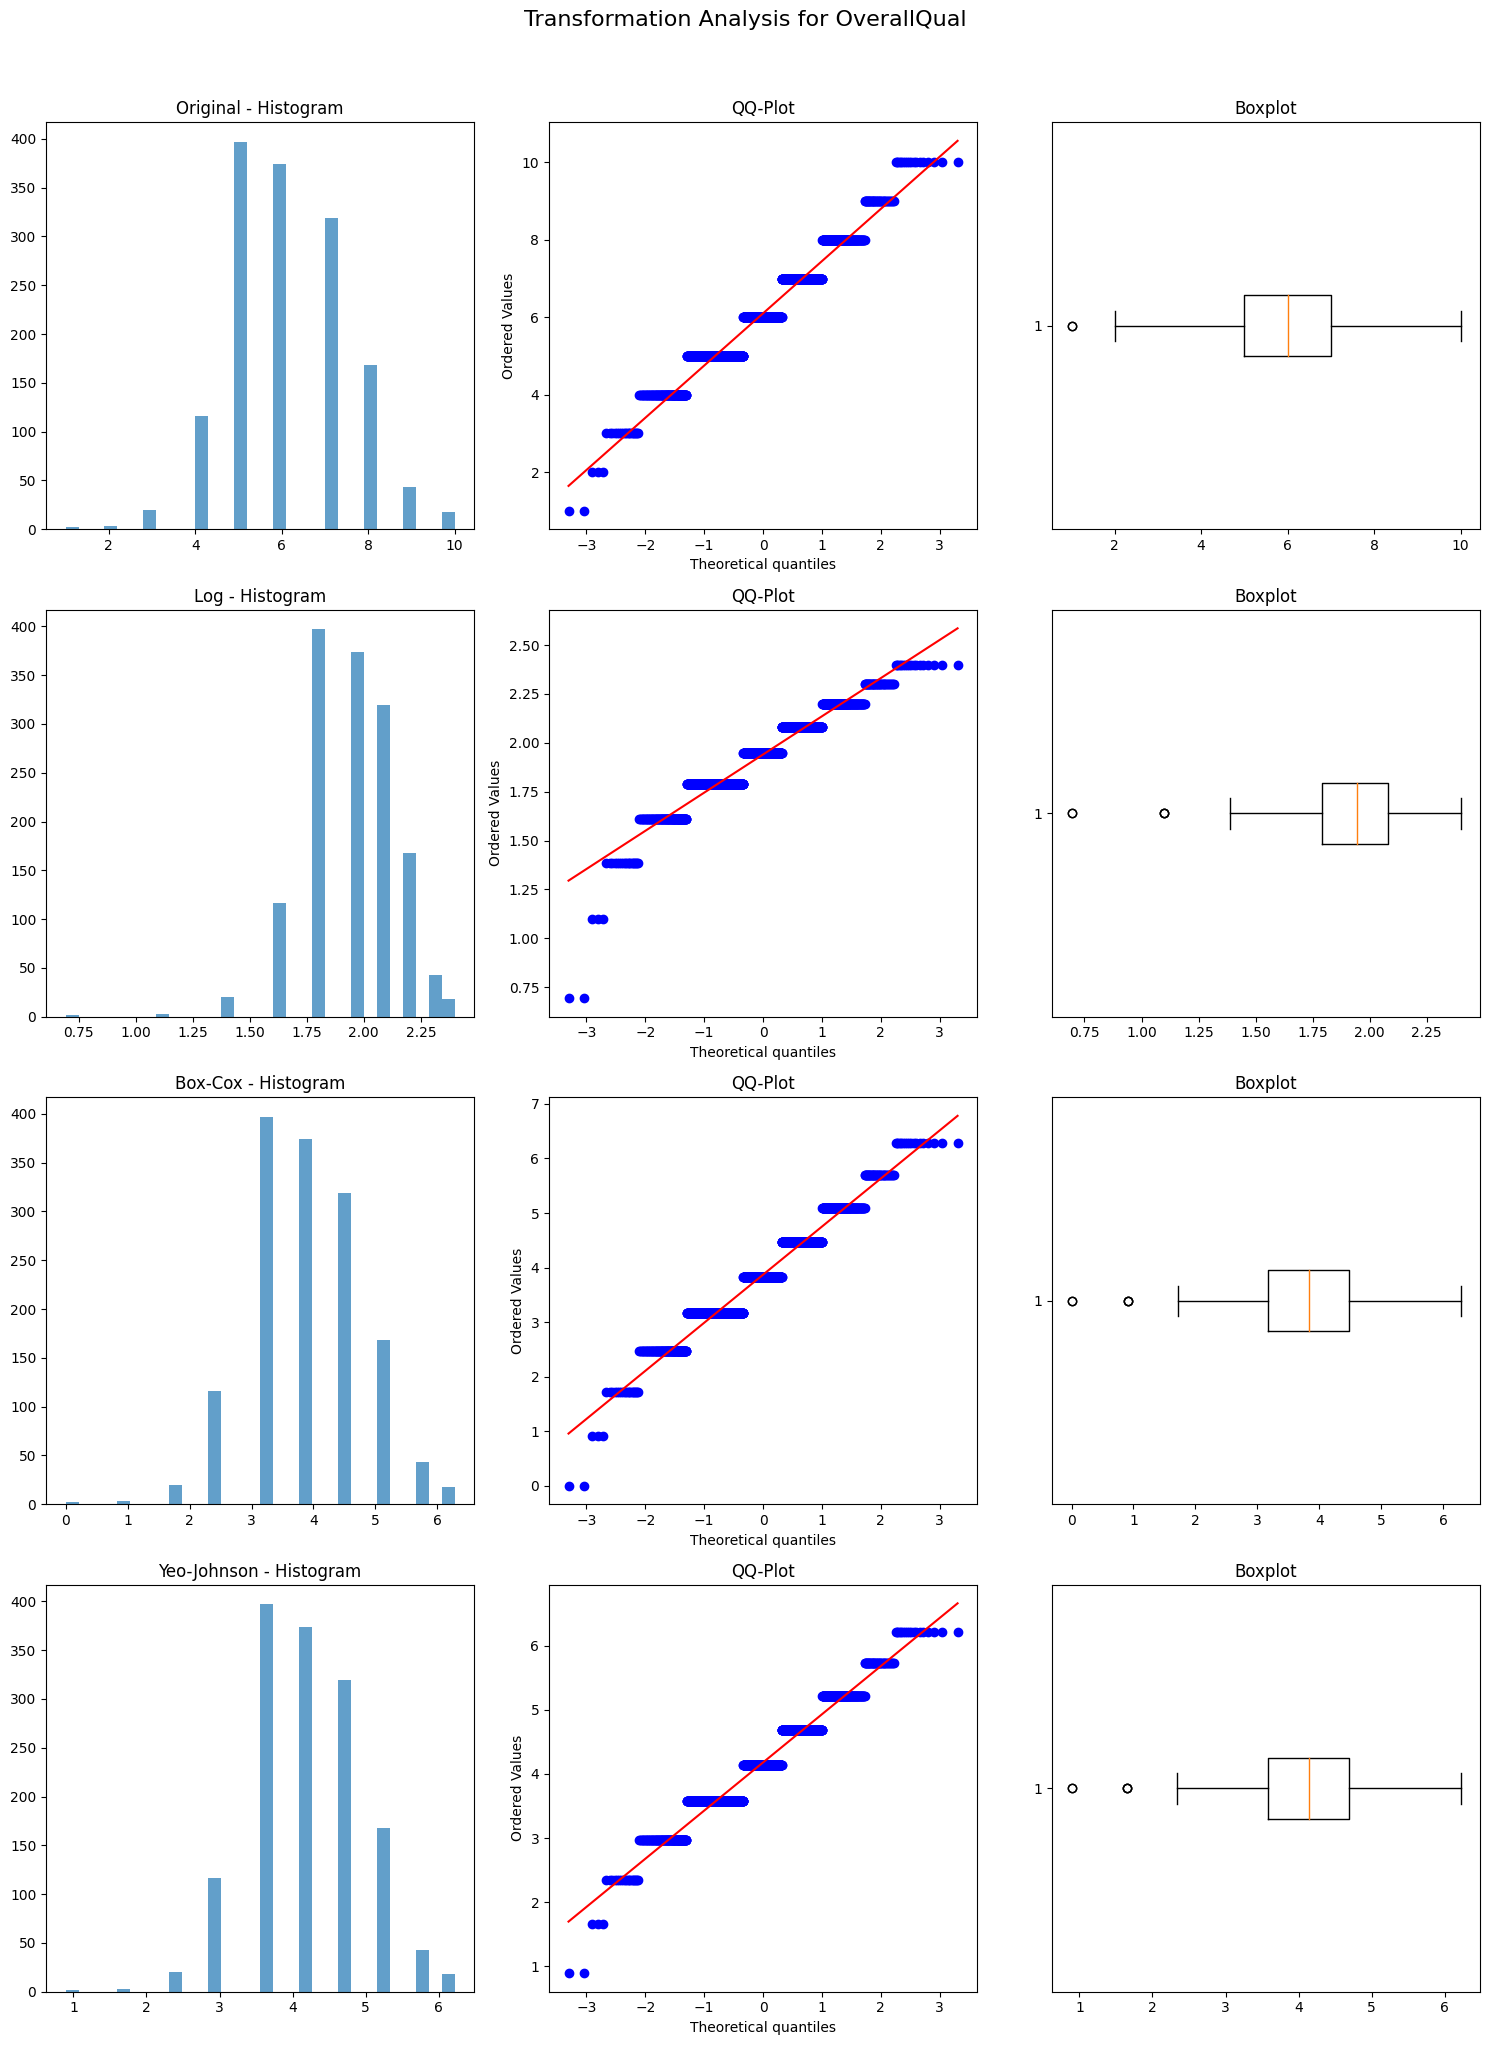

Analyzing transformations for: GarageArea
Shifting GarageArea by 1.0 for Box-Cox transformation.


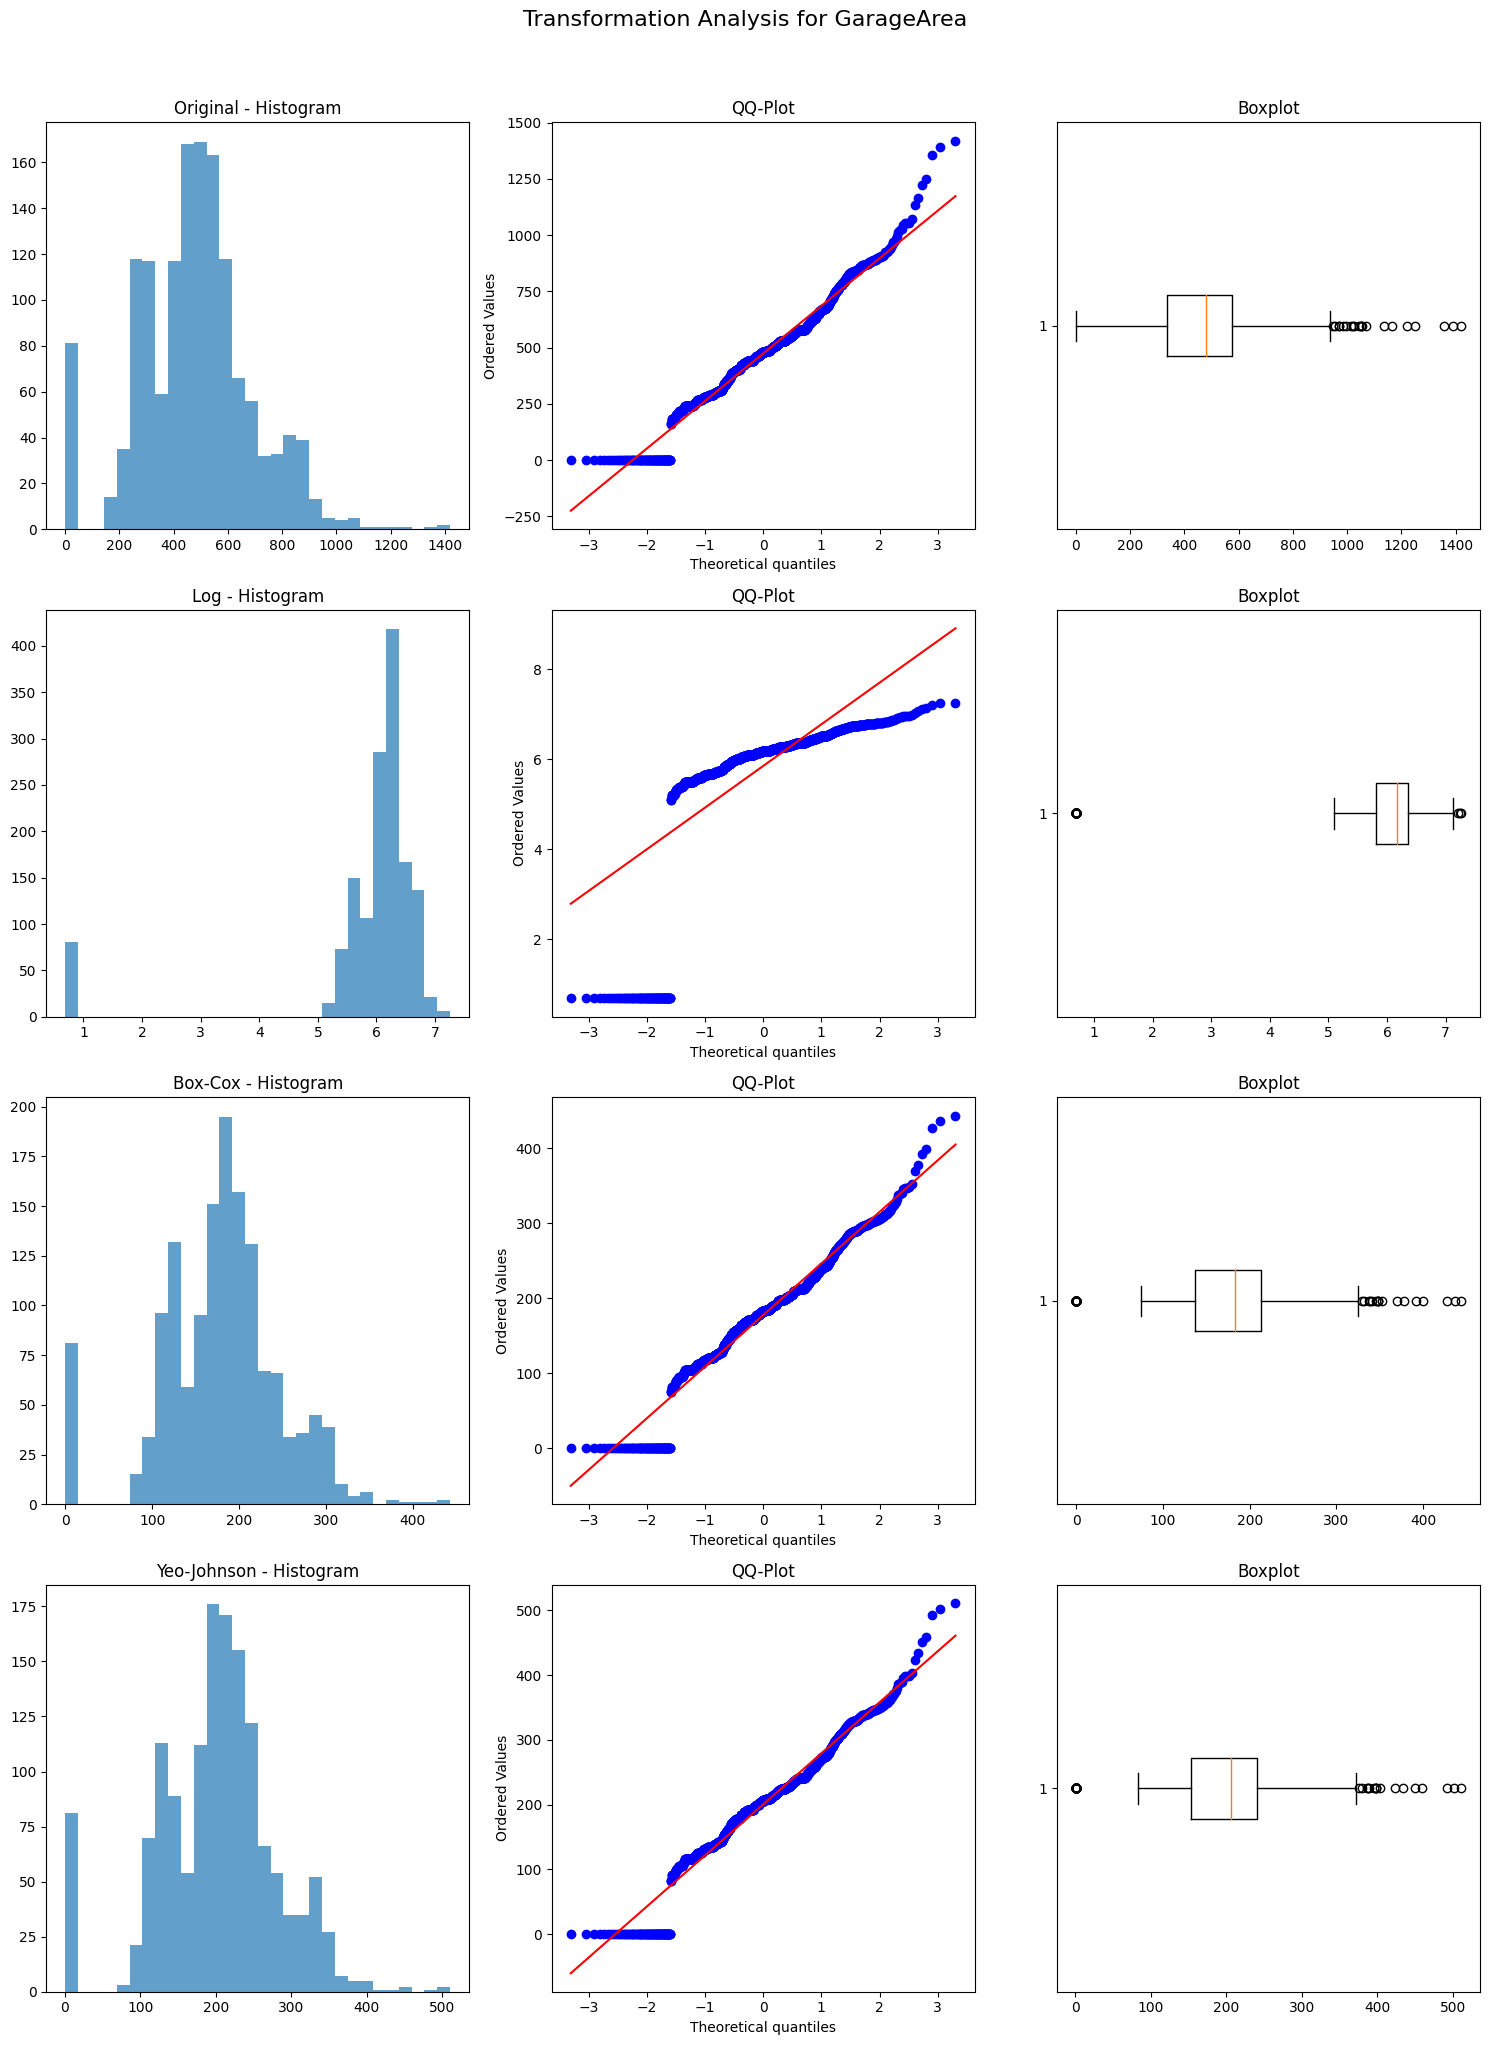

Analyzing transformations for: TotalBsmtSF
Shifting TotalBsmtSF by 1.0 for Box-Cox transformation.


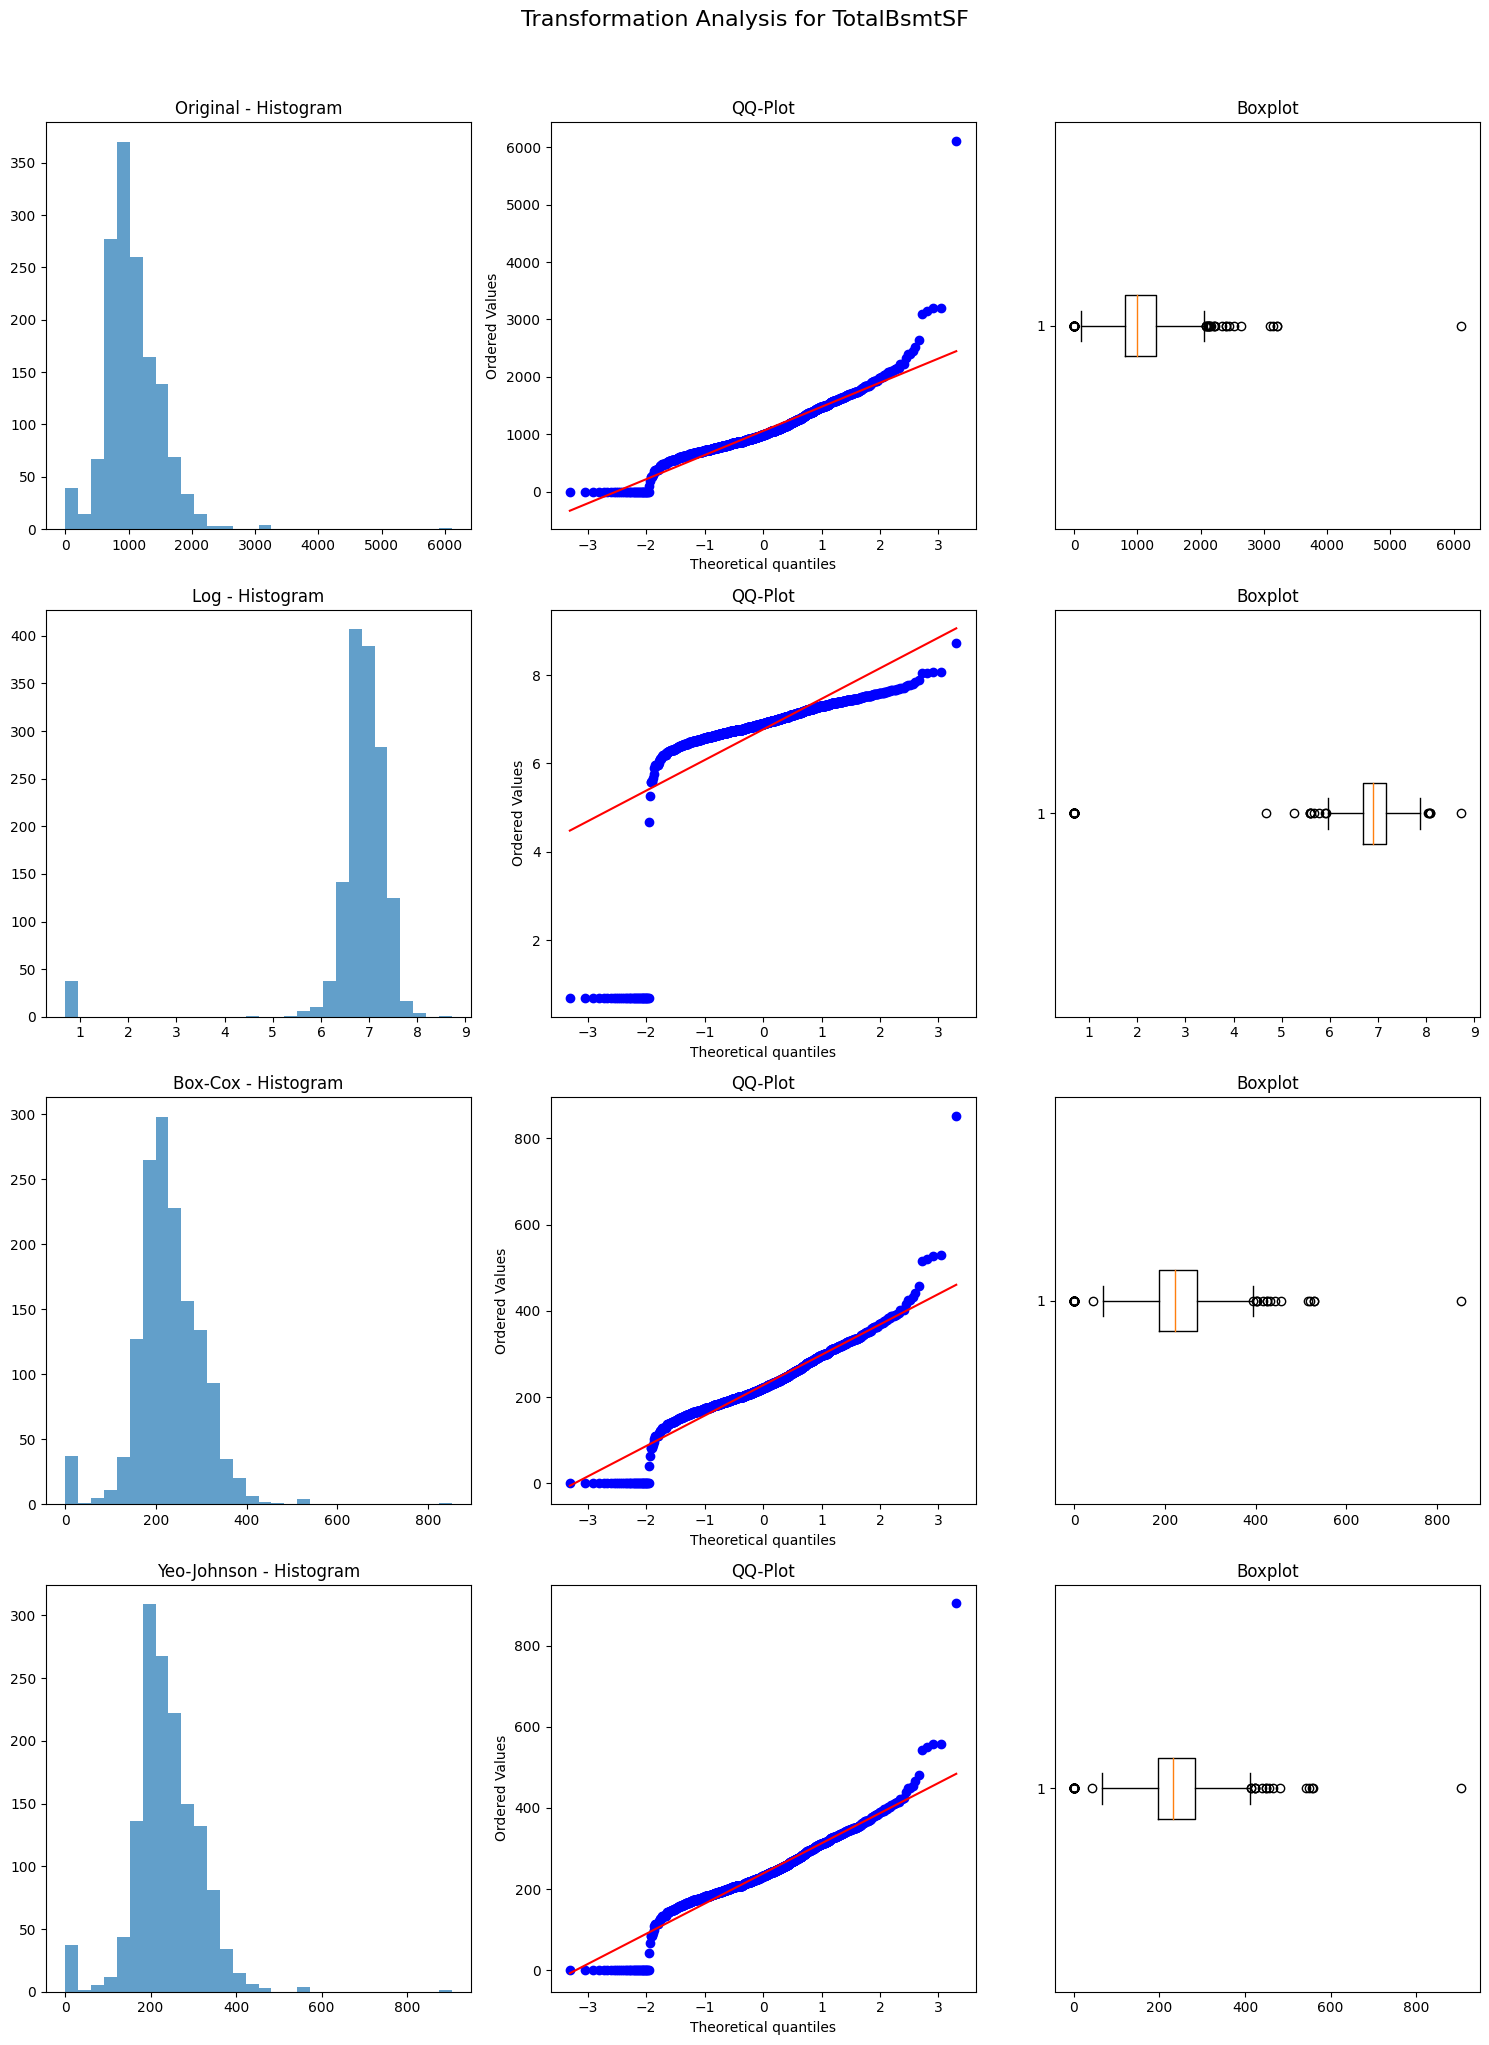

Analyzing transformations for: YearBuilt


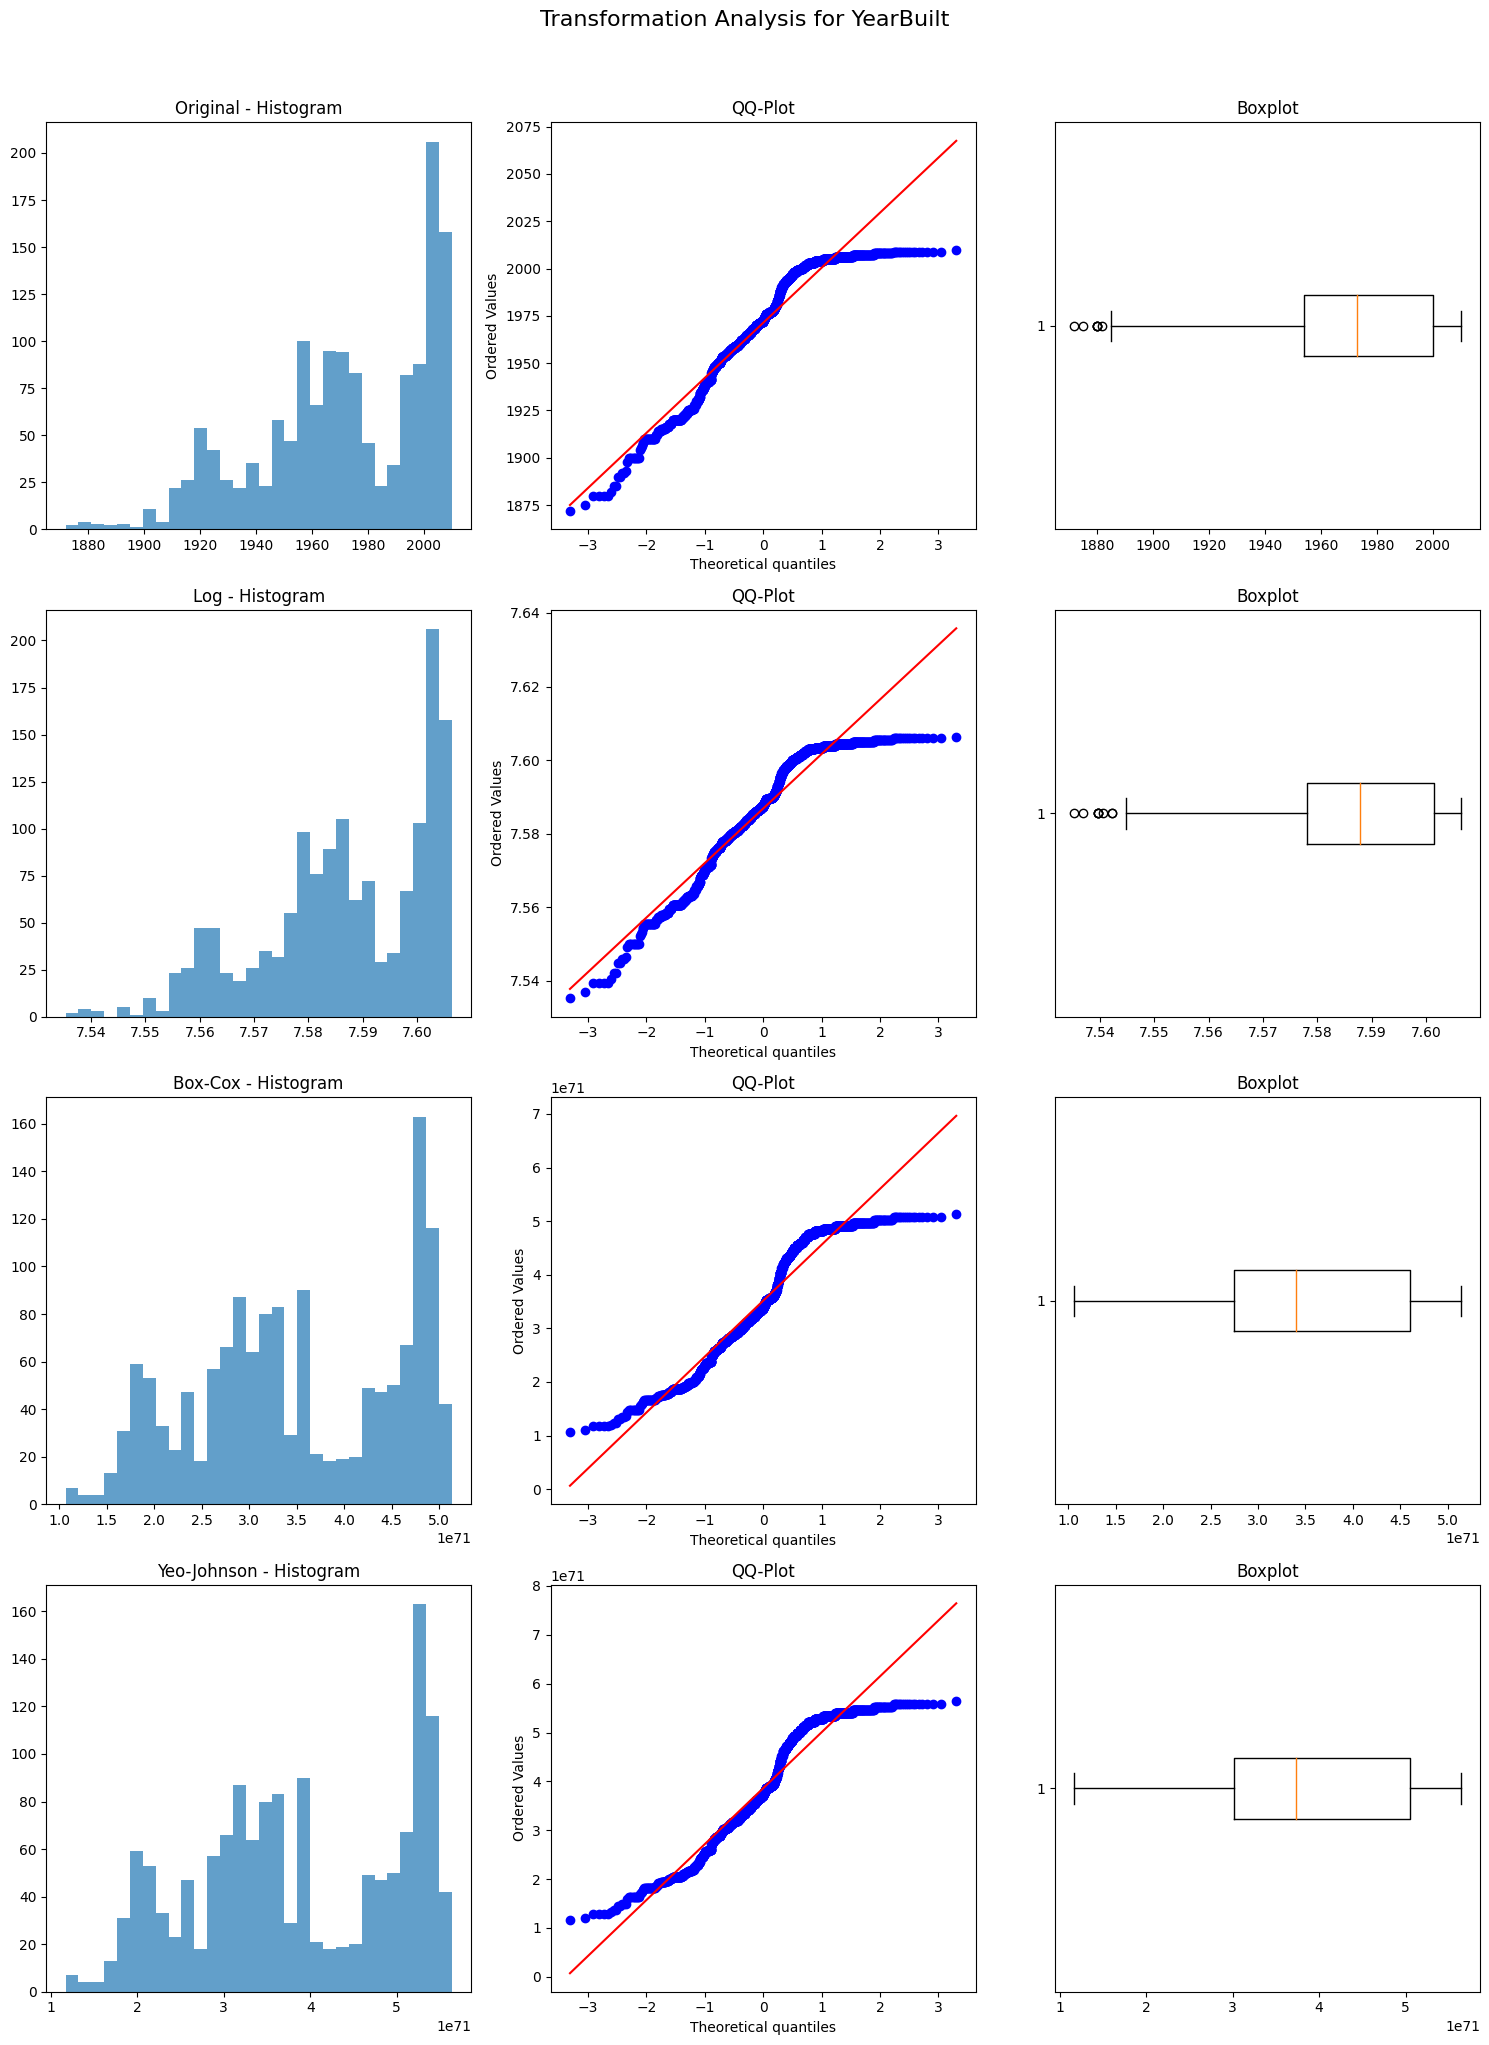

In [10]:
# Analyze transformations for strongly correlated variables
strong_corr_variables = ['GrLivArea', 'OverallQual', 'GarageArea', 'TotalBsmtSF', 'YearBuilt']

for variable in strong_corr_variables:
    print(f"Analyzing transformations for: {variable}")
    compare_transformations(df_cleaned, variable)

* **GrLivArea** and **TotalBsmtSF** Both have skewed distributions, which can negatively affect the model. The Box-Cox transformation works well here, as it reduces skewness and the impact of extreme values. This should help the model better understand these variables.

* **OverallQual** This is a categorical variable representing house quality. Since it already has a discrete structure, transformations don’t improve it. I’m keeping it as is, as it provides meaningful levels directly to the model.

* **GarageArea** This variable has some skewness and can include zero values. Yeo-Johnson is the best choice here because it handles zeros and smooths the distribution effectively, which should improve model performance.

* **YearBuilt** This variable is based on time, so having a perfect normal distribution isn’t very important. However, the Box-Cox transformation makes the data smoother. I might also group the years into categories to help the model find patterns more easily.

In [11]:
print("Min value of GrLivArea:", df_cleaned['GrLivArea'].min())
print("Min value of TotalBsmtSF:", df_cleaned['TotalBsmtSF'].min())

Min value of GrLivArea: 334.0
Min value of TotalBsmtSF: 0.0


In [13]:
# Add 1 to TotalBsmtSF to handle zero values
df_cleaned['TotalBsmtSF'] += 1

# Create a pipeline for transformations
pipeline = Pipeline([
    ('box_cox_grlivarea', BoxCoxTransformer(variables=['GrLivArea', 'TotalBsmtSF'])),
    ('yeo_johnson_garagearea', YeoJohnsonTransformer(variables=['GarageArea']))
])

# Apply the pipeline to the cleaned dataset
df_transformed = pipeline.fit_transform(df_cleaned)

# Save the pipeline
dump(pipeline, "outputs/pipelines/feature_pipeline.pkl")
print("Feature engineering pipeline saved successfully.")

# Add categorical groups for YearBuilt
df_transformed['YearBuilt_Group'] = pd.cut(df_cleaned['YearBuilt'], 
                                           bins=[-np.inf, 1900, 1950, 2000, np.inf], 
                                           labels=['Very Old', 'Old', 'Modern', 'Recent'])

print(df_transformed[['GrLivArea', 'TotalBsmtSF', 'GarageArea', 'YearBuilt_Group']].head())



Feature engineering pipeline saved successfully.
   GrLivArea  TotalBsmtSF  GarageArea YearBuilt_Group
0   7.621711   207.344799  204.517915          Recent
1   7.303622   277.455826  177.329636          Modern
2   7.667292   218.876244  222.579733          Recent
3   7.625993   188.879521  232.664362             Old
4   7.885038   257.927823  288.451992          Modern


In [14]:
df_transformed.to_csv("outputs/datasets/collection/HousePricesTransformed.csv", index=False)

___

In [29]:
# Identify and OneHotEncode categorical variables
one_hot_encoder = OneHotEncoder(variables=['KitchenQual', 'GarageFinish', 'BsmtExposure', 'BsmtFinType1'])

# Apply OneHotEncoding on the transformed dataset
df_transformed_encoded = one_hot_encoder.fit_transform(df_transformed)

# Select only numerical features for SmartCorrelatedSelection
df_numeric = df_transformed_encoded.select_dtypes(include=['float64', 'int64'])

# SmartCorrelatedSelection to remove highly correlated features
smart_corr = SmartCorrelatedSelection(
    method="spearman",  # Use rank correlation
    threshold=0.7       # Correlation threshold
)
df_reduced = smart_corr.fit_transform(df_numeric)

# Print the removed features for transparency
removed_features = smart_corr.features_to_drop_
print("Features removed due to high correlation:")
print(removed_features)

# Ensure 'SalePrice' is in the reduced dataset
if 'SalePrice' not in df_reduced.columns:
    df_reduced['SalePrice'] = df_numeric['SalePrice']

# Ensure GrLivArea is in the final dataset
if 'GrLivArea' not in df_reduced.columns:
    df_reduced['GrLivArea'] = df_numeric['GrLivArea']

# Ensure TotalBsmtSF is in the final dataset
if 'TotalBsmtSF' not in df_reduced.columns:
    df_reduced['TotalBsmtSF'] = df_numeric['TotalBsmtSF']

# Filter features with correlation > 0.5 with SalePrice
correlation_matrix = df_reduced.corr()
threshold = 0.2
high_corr_features = correlation_matrix['SalePrice'][abs(correlation_matrix['SalePrice']) > threshold].index.tolist()

# Ensure GrLivArea is included even if its correlation is slightly lower
if 'GrLivArea' not in high_corr_features:
    high_corr_features.append('GrLivArea')

# Keep only the high correlation features
df_selected = df_reduced[high_corr_features]

# Log final feature names and dataset shape
print("Selected features with correlation > 0.2 (and GrLivArea):")
print(df_selected.columns.tolist())
print(f"Shape of the final dataset: {df_selected.shape}")

Features removed due to high correlation:
['GrLivArea', 'TotalBsmtSF', 'YearBuilt', 'KitchenQual_Gd', 'BsmtFinType1_Unf']
Selected features with correlation > 0.2 (and GrLivArea):
['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GarageYrBlt', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallQual', 'YearRemodAdd', 'SalePrice', 'KitchenQual_TA', 'KitchenQual_Ex', 'GarageFinish_Unf', 'GarageFinish_Fin', 'BsmtExposure_No', 'BsmtExposure_Gd', 'BsmtFinType1_GLQ', 'GrLivArea', 'TotalBsmtSF']
Shape of the final dataset: (1460, 22)


___

In [16]:
# Filter correlations above a threshold in the reduced dataset
threshold = 0.2
correlation_matrix_reduced = df_selected.corr()  # Create the correlation matrix for df_selected
high_corr = correlation_matrix_reduced['SalePrice'][abs(correlation_matrix_reduced['SalePrice']) > threshold]
print("Variables with high correlation with SalePrice:")
print(high_corr.sort_values(ascending=False))


Variables with high correlation with SalePrice:
SalePrice           1.000000
OverallQual         0.790982
GrLivArea           0.695364
GarageArea          0.608821
1stFlrSF            0.605852
TotalBsmtSF         0.602470
YearRemodAdd        0.507101
KitchenQual_Ex      0.504094
MasVnrArea          0.472614
GarageYrBlt         0.466754
BsmtFinType1_GLQ    0.400764
BsmtFinSF1          0.386420
GarageFinish_Fin    0.376918
LotFrontage         0.334771
OpenPorchSF         0.315856
2ndFlrSF            0.312479
BsmtExposure_Gd     0.307298
LotArea             0.263843
BsmtUnfSF           0.214479
BsmtExposure_No    -0.319990
GarageFinish_Unf   -0.439573
KitchenQual_TA     -0.519298
Name: SalePrice, dtype: float64


___

* **Encode categorical variables:** Turn category columns into numbers so the model can use them.
* **Boolean columns:** Change True/False to 0 and 1 for the model.
* **Separate columns:** Split numeric and category columns to handle them better, like scaling numbers.

In [17]:
# Filter features with correlation > 0.5 with SalePrice
threshold = 0.2

# Compute the correlation matrix for df_selected
correlation_matrix = df_selected.corr()

# Select features with correlation > 0.5 with SalePrice
high_corr_features = correlation_matrix['SalePrice'][abs(correlation_matrix['SalePrice']) > threshold].index.tolist()

# Remove 'SalePrice' from the list
high_corr_features.remove('SalePrice')

# Keep only features strongly correlated with SalePrice (> 0.5)
X_combined = df_selected[high_corr_features].copy()

# Add SalePrice back to the dataset for visualization purposes
X_combined['SalePrice'] = df_selected['SalePrice']

print(f"Features selected based on correlation > {threshold}: {high_corr_features}")

Features selected based on correlation > 0.2: ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GarageYrBlt', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallQual', 'YearRemodAdd', 'KitchenQual_TA', 'KitchenQual_Ex', 'GarageFinish_Unf', 'GarageFinish_Fin', 'BsmtExposure_No', 'BsmtExposure_Gd', 'BsmtFinType1_GLQ', 'GrLivArea', 'TotalBsmtSF']


* Combine columns to put all the numeric and encoded category columns together in one dataset.
* Scale numbers to make all numeric values similar in range to help the model work better.

In [18]:
# Create a pipeline to scale numbers
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

* Scale the numeric features so they are all on a similar range.
* Add 'SalePrice' to the transformed dataset.
* Print the dataset size, first few rows, and data types after transformation.
* Print an error message if something goes wrong.

In [19]:
try:
    # Scale numerical features using the pipeline
    X_combined_scaled = pd.DataFrame(
        pipeline.fit_transform(X_combined), 
        columns=X_combined.columns
    )

    # Display information about the transformed dataset
    print("Transformed dataset size:", X_combined_scaled.shape)
    print(X_combined_scaled.head())
    print(X_combined_scaled.dtypes)

except Exception as e:
    print("Error during pipeline execution:", e)

Transformed dataset size: (1460, 22)
   1stFlrSF  2ndFlrSF  BsmtFinSF1  BsmtUnfSF  GarageArea  GarageYrBlt  \
0 -0.793434  1.213595    0.575425  -0.944591    0.383899     1.017598   
1  0.257140 -0.756746    1.171992  -0.641228   -0.004602    -0.107927   
2 -0.627826  1.241281    0.092907  -0.301643    0.641990     0.934226   
3 -0.521734 -0.756746   -0.499274  -0.061670    0.786092     0.809167   
4 -0.045611 -0.756746    0.463568  -0.174865    1.583257     0.892540   

    LotArea  LotFrontage  MasVnrArea  OpenPorchSF  ...  KitchenQual_TA  \
0 -0.207142    -0.220875    0.514104     0.216503  ...       -1.006873   
1 -0.091886     0.460320   -0.570750    -0.704483  ...        0.993174   
2  0.073480    -0.084636    0.325915    -0.070361  ...       -1.006873   
3 -0.096897    -0.447940   -0.570750    -0.176048  ...       -1.006873   
4  0.375148     0.641972    1.366489     0.563760  ...       -1.006873   

   KitchenQual_Ex  GarageFinish_Unf  GarageFinish_Fin  BsmtExposure_No  \
0    

___

In [20]:
# Print the shape and columns of the DataFrame to verify changes after operations
print("X_combined shape:", X_combined.shape)
print("Columns in X_combined:", X_combined.columns.tolist())

X_combined shape: (1460, 22)
Columns in X_combined: ['1stFlrSF', '2ndFlrSF', 'BsmtFinSF1', 'BsmtUnfSF', 'GarageArea', 'GarageYrBlt', 'LotArea', 'LotFrontage', 'MasVnrArea', 'OpenPorchSF', 'OverallQual', 'YearRemodAdd', 'KitchenQual_TA', 'KitchenQual_Ex', 'GarageFinish_Unf', 'GarageFinish_Fin', 'BsmtExposure_No', 'BsmtExposure_Gd', 'BsmtFinType1_GLQ', 'GrLivArea', 'TotalBsmtSF', 'SalePrice']


Create a **heatmap** to visualize the correlation matrix **after** Feature Engineering

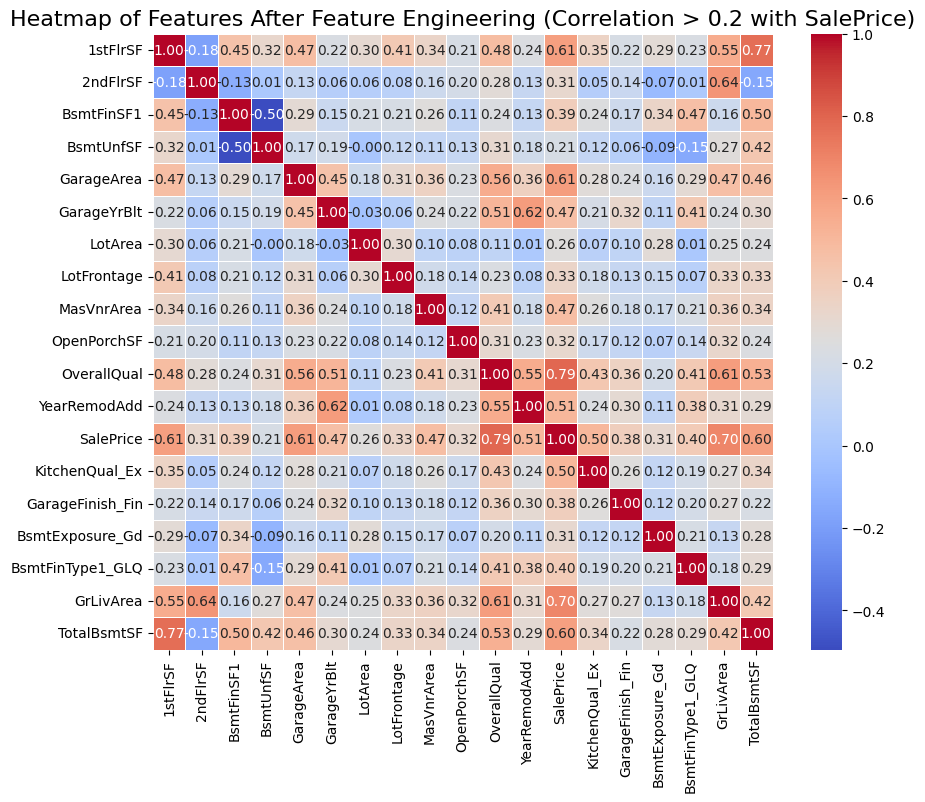

In [21]:
# Compute the correlation matrix for the selected features
correlation_matrix_after = df_selected.corr()

# Filter variables with correlation > 0.2 with SalePrice (only positive correlations)
threshold = 0.2
high_corr = correlation_matrix_after['SalePrice'][
    (correlation_matrix_after['SalePrice'] > threshold)
]

# Get the names of relevant variables (including SalePrice)
relevant_vars = high_corr.index.tolist()

# Create a filtered correlation matrix with only these variables
filtered_corr_matrix = correlation_matrix_after.loc[relevant_vars, relevant_vars]

# Plot heatmap for variables with high correlation
plt.figure(figsize=(10, 8))
sns.heatmap(filtered_corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5, cbar=True)
plt.title("Heatmap of Features After Feature Engineering (Correlation > 0.2 with SalePrice)", fontsize=16)
plt.show()


**Correlation Matrix After Feature Engineering**

The updated correlation matrix shows that feature engineering did not change the correlations between the features and the target variable **SalePrice**.

* **OverallQual (0.79)** This feature has the strongest positive correlation with SalePrice, indicating that higher-quality homes tend to sell for more. This makes it a key predictor for the model.

* **GrLivArea (0.70)** and **GarageArea (0.61)** Both still show strong positive correlations with SalePrice, showing they are important for predicting house prices.

The feature engineering process aimed to explore new predictors and reduce redundancy, but the existing features remain the most significant contributors to the model. By focusing on strongly correlated features like OverallQual, GrLivArea, and GarageArea, the model can effectively predict house prices while avoiding the inclusion of less impactful features.

___

Feature importance before filtering:
       Feature  Importance
1  OverallQual    0.417433
0    GrLivArea    0.217368
3  TotalBsmtSF    0.139977
2   GarageArea    0.080569


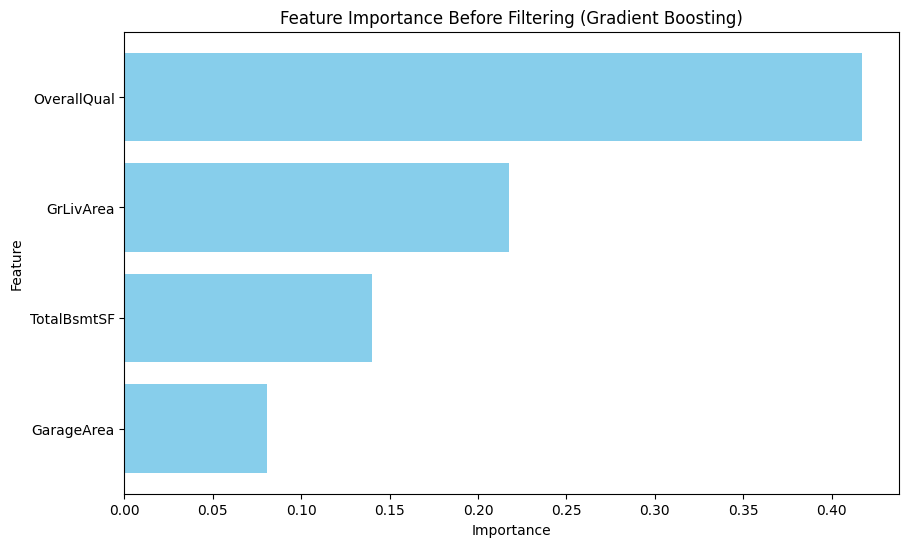

In [22]:
# Prepare data with all numerical features
X_all = df_cleaned[['GrLivArea', 'OverallQual', 'GarageArea', 'TotalBsmtSF']]
y_all = np.log1p(df_cleaned['SalePrice'])  # Log-transform target variable

# Train a Gradient Boosting model
model = GradientBoostingRegressor(random_state=42)
model.fit(X_all, y_all)

# Calculate permutation importance
perm_importance = permutation_importance(model, X_all, y_all, n_repeats=10, random_state=42)

# Create a DataFrame for importance
importance_df = pd.DataFrame({
    'Feature': X_all.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

# Display importance values
print("Feature importance before filtering:")
print(importance_df)

# Visualize importance
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='skyblue')
plt.title('Feature Importance Before Filtering (Gradient Boosting)')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.gca().invert_yaxis()
plt.show()



### Hypothesis 1

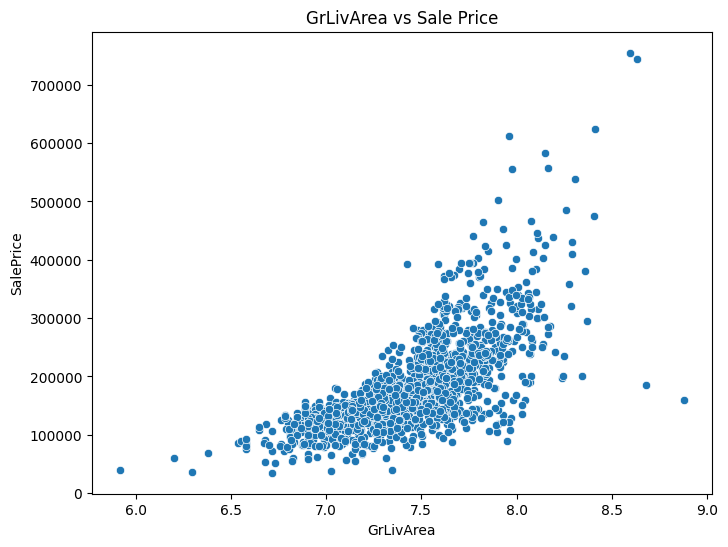

In [23]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=X_combined)
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.title('GrLivArea vs Sale Price')
plt.show()

### Hypothesis 1 Confirmed
The scatter plots and correlation analysis show a positive relationship between the total area of the house and its sale price, confirming the initial hypothesis that bigger houses tend to have higher sale prices.

___

### Hypothesis 2

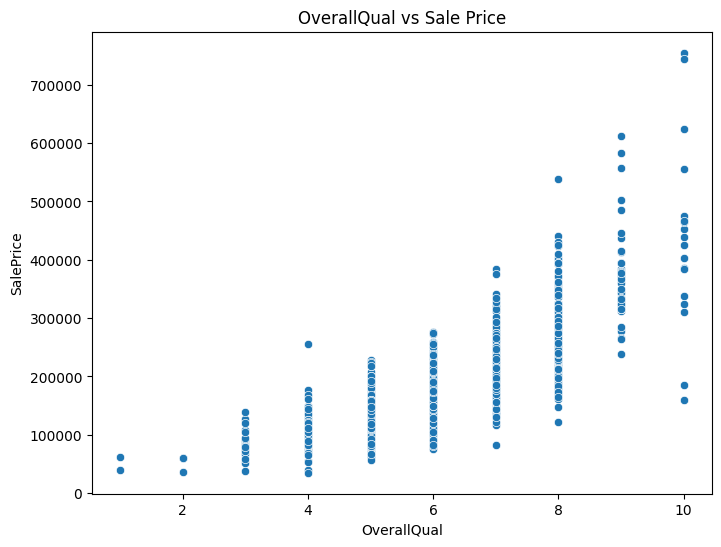

In [24]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='OverallQual', y='SalePrice', data=X_combined)
plt.xlabel('OverallQual')
plt.ylabel('SalePrice')
plt.title('OverallQual vs Sale Price')
plt.show()

### Hypothesis 2 Confirmed
* The scatter plot and correlation analysis show a strong positive link between OverallQual and SalePrice. With a correlation of 0.79, higher quality homes tend to sell for more. This confirms that home quality affects its sale price.

___

### Hypothesis 3

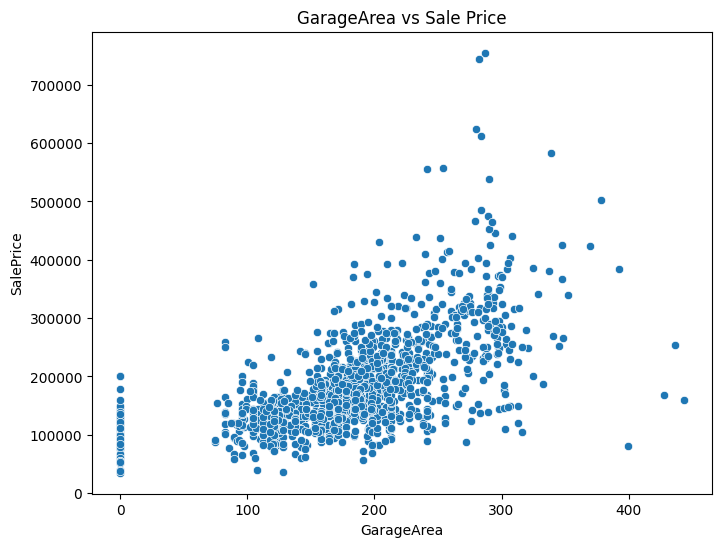

In [25]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x='GarageArea', y='SalePrice', data=X_combined)
plt.xlabel('GarageArea')
plt.ylabel('SalePrice')
plt.title('GarageArea vs Sale Price')
plt.show()

### Hypothesis 3 Confirmed
The scatter plot and correlation analysis show a positive relationship between 'GarageArea' and 'SalePrice'. This confirms the hypothesis that houses with bigger garages tend to sell for higher prices.

___

In [26]:
# Check which features exist in the current dataset
existing_features = X_combined.columns.tolist()

# Define the features you want to keep
selected_features = ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'SalePrice']

# Filter out features that do not exist in the current dataset
valid_selected_features = [feature for feature in selected_features if feature in existing_features]

# Restrict the dataset to the selected features
X_reduced = X_combined[valid_selected_features]

# Save selected features for later use
with open("outputs/selected_features.json", "w") as f:
    json.dump(valid_selected_features, f)
print("Selected features saved successfully.")

print(f"Final selected features: {valid_selected_features}")


Selected features saved successfully.
Final selected features: ['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'SalePrice']


### Selected Features

The following features were chosen for the model along with `SalePrice` (the target), based on their high correlation with the target and/or their importance in feature importance analysis:

- **OverallQual**: Represents the overall quality of the house, with a strong correlation to `SalePrice` (0.79).
- **GrLivArea**: Total living area above ground, which also has a strong positive correlation to `SalePrice` (0.70).
- **GarageArea**: Size of the garage area, which has a reasonable correlation to `SalePrice` (0.61) and was marked as important in the feature importance analysis.
- **TotalBsmtSF**: Total basement area, an important predictor for house prices, with a correlation of 0.60.
- **SalePrice**: The target variable.

### Reasoning

These features were selected because they have strong relationships with `SalePrice` and were identified as important in the feature importance analysis. Using these features helps focus on the most relevant data, and may reduce the risk of overfitting.


## Push files to repo

In [27]:
# Export the filtered dataset with selected features
X_reduced.to_csv("outputs/datasets/collection/HousePricesFeaturesSelected.csv", index=False)

In [28]:
# Summary of Selected Features
print("Feature Engineering Summary:")

# Total number of features in the original dataset
features_before_selection = len(X_combined.columns)
print(f"Total number of features before selection: {features_before_selection}")

# Total number of features after selection
features_after_selection = len(['OverallQual', 'GrLivArea', 'GarageArea', 'TotalBsmtSF', 'SalePrice'])
print(f"Total number of features after selection: {features_after_selection}")

# Number of features removed
features_removed = features_before_selection - features_after_selection
print(f"Number of features removed: {features_removed}")


Feature Engineering Summary:
Total number of features before selection: 22
Total number of features after selection: 5
Number of features removed: 17


### Feature Engineering Summary

* No new features had a correlation higher than 0.5 with **SalePrice**, so they were not added to the final dataset.
* Original features like **GrLivArea (0.66)**, **OverallQual (0.79)**, and **GarageArea (0.61)** are still the best predictors of SalePrice.
* Visualizations showed a clear positive relationship between these features and **SalePrice**, confirming their importance.
* Features were scaled, one-hot encoded where needed, and checked for missing values to prepare them for modeling.
* Hypotheses 1, 2, and 3 were confirmed and added to the README.
* The final dataset is ready for modeling, with selected features that strongly relate to **SalePrice**.